In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf 
import matplotlib.pyplot as plt
import json

2023-03-19 19:00:24.212444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 19:00:24.325323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-19 19:00:24.325341: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-19 19:00:24.343925: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-19 19:00:24.895292: W tensorflow/stream_executor/platform/de

# Import Data

In [2]:
dataset = pd.read_csv('data.csv', index_col=0)
dataset.head()

,index,middle,ring,pinky,label
0,"[-10.126666666666551, -10.026666666666586, -9....","[-15.720000000000141, -15.720000000000141, -15...","[0.2600000000002183, 0.2600000000002183, 0.360...","[8.00333333333333, 7.903333333333308, 7.803333...",2-0
1,"[-11.59666666666675, -11.59666666666675, -11.4...","[-16.683333333333508, -16.683333333333508, -16...","[-0.5866666666667015, -0.5866666666667015, -0....","[2.106666666666797, 2.2066666666668198, 2.1066...",2-0
2,"[-7.816666666666663, -7.71666666666664, -7.616...","[-7.050000000000068, -7.050000000000068, -7.05...","[0.9633333333334804, 0.8633333333335713, 0.763...","[-2.28999999999985, -2.28999999999985, -2.2899...",2-0
3,"[-5.670000000000016, -5.670000000000016, -5.57...","[-28.286666666666633, -28.286666666666633, -28...","[-1.6633333333334122, -1.6633333333334122, -1....","[2.1299999999998818, 2.029999999999859, 2.1299...",2-0
4,"[-0.38333333333332575, -0.38333333333332575, -...","[-11.653333333333421, -11.653333333333421, -11...","[-4.346666666666465, -4.346666666666465, -4.24...","[-1.033333333333303, -1.1333333333333258, -1.1...",2-0


# Create Train/Val/Test Dataset

In [3]:
## X
n_steps = len(json.loads(dataset.iloc[0,0]))
n_features = 4
X = np.empty((dataset.shape[0], n_steps*n_features), dtype=np.float64)
for i in range(X.shape[0]):    
    x = []
    for j in range(n_features):
        arr = list(json.loads(dataset.iloc[i,j]))
        x += arr
    X[i] = np.array(x)

## y
labels = dataset["label"].to_numpy()
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
n_classes = len(np.unique(y_encoded))
y = to_categorical(y_encoded)

## split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Model Training

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_dense (Dense)         (None, 128)               15488     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 second_dense (Dense)        (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 third_dense (Dense)         (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 fourth_dense (Dense)        (None, 32)                1

2023-03-19 19:00:32.210149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 19:00:32.210357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-19 19:00:32.210411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-19 19:00:32.210449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-19 19:00:32.210486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

20/20 [==============================] - 0s 8ms/step - loss: 6.6324 - accuracy: 0.0672 - val_loss: 2.7018 - val_accuracy: 0.2750
Epoch 2/400
20/20 [==============================] - 0s 2ms/step - loss: 3.1875 - accuracy: 0.1250 - val_loss: 2.3813 - val_accuracy: 0.3187
Epoch 3/400
20/20 [==============================] - 0s 2ms/step - loss: 2.7481 - accuracy: 0.1695 - val_loss: 2.1497 - val_accuracy: 0.3750
Epoch 4/400
20/20 [==============================] - 0s 2ms/step - loss: 2.5403 - accuracy: 0.2102 - val_loss: 1.9825 - val_accuracy: 0.3688
Epoch 5/400
20/20 [==============================] - 0s 2ms/step - loss: 2.3094 - accuracy: 0.2992 - val_loss: 1.7309 - val_accuracy: 0.4531
Epoch 6/400
20/20 [==============================] - 0s 2ms/step - loss: 2.1029 - accuracy: 0.3391 - val_loss: 1.5269 - val_accuracy: 0.5219
Epoch 7/400
20/20 [==============================] - 0s 2ms/step - loss: 1.9309 - accuracy: 0.3891 - val_loss: 1.2798 - val_accuracy: 0.6406
Epoch 8/400
20/20 [======

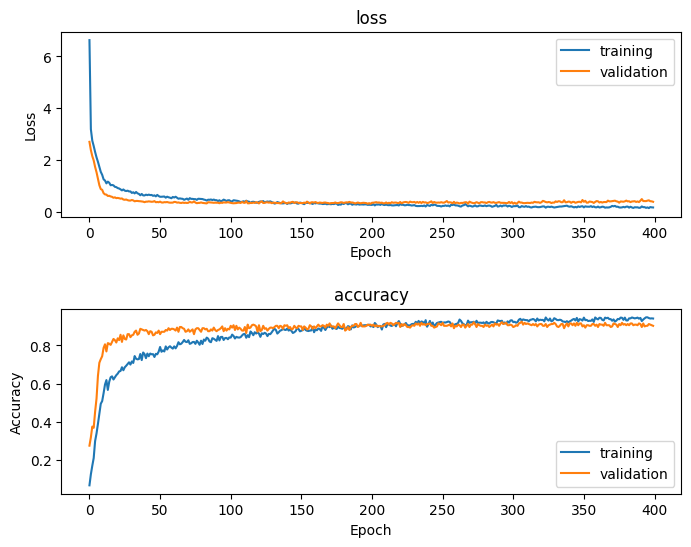

In [4]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(120,), name='first_dense'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', name='second_dense'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', name='third_dense'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', name='fourth_dense'))
model.add(Dense(20, activation='softmax', name='final_dense'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the MLP model.
history = model.fit(x_train, y_train, epochs=400, batch_size=64, validation_data=(x_val, y_val))
fig, axes = plt.subplots(2,1, figsize=(8,6))
axes[0].plot(history.epoch,history.history['loss'], label='training')
axes[0].plot(history.epoch,history.history['val_loss'], label='validation')
axes[0].set_title('loss')
axes[0].legend(loc='best')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
fig.subplots_adjust(hspace=0.5)
axes[1].plot(history.epoch,history.history['accuracy'], label='training')
axes[1].plot(history.epoch,history.history['val_accuracy'], label='validation')
axes[1].set_title('accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='best');

In [5]:
print("Train accuracy:", history.history["accuracy"][-1])
print("Validation accuracy:", history.history["val_accuracy"][-1])
print("Test accuracy:", model.evaluate(x_test, y_test, verbose=0)[1])

Train accuracy: 0.94140625
Validation accuracy: 0.903124988079071
Test accuracy: 0.9399999976158142


# Model Evaluation

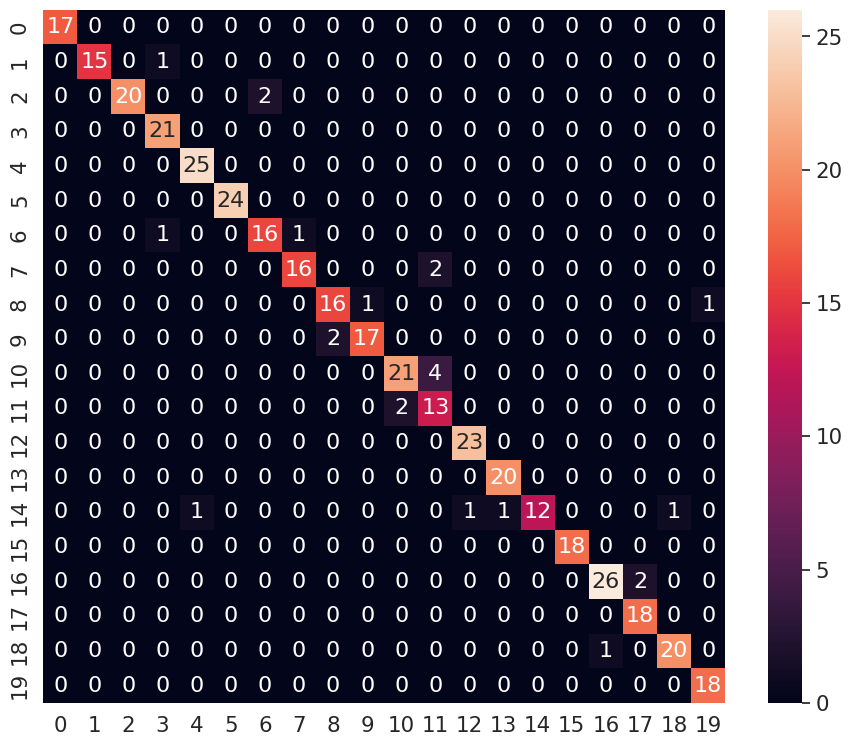

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = model.predict(x_test, verbose=0)
y_pred_rd = np.argmax(y_pred, axis=1)
y_test_rd = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_rd, y_pred_rd)
# plt.figure(figsize=(40,40))
# plt.matshow(cm)
df_cm = pd.DataFrame(cm, range(20), range(20))
plt.figure(figsize=(11,9))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()


In [7]:
import time 

start = time.time()
y_prediction = model.predict(x_test) 
end = time.time()

print("Inference time: %f ms" % ((end - start)/x_test.shape[0] * 1000))

13/13 [==============================] - 0s 568us/step
Inference time: 0.117632 ms
